# Deep learning model comparison
This notebook contains the implementation and evaluation of various neural network models with differing paremeters.

In [1]:
%pylab inline
%load_ext autoreload
%autoreload 2

%aimport manual_review_classifier

Populating the interactive namespace from numpy and matplotlib


In [2]:
%matplotlib inline

In [3]:
import numpy as np
import pandas as pd
import os
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasClassifier
from keras.regularizers import l2
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_predict
from sklearn import preprocessing
from sklearn import metrics
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns
from itertools import cycle

from manual_review_classifier.ClassifierPlots import create_reliability_diagram, create_roc_curve, create_feature_importance_plot, make_model_output_plot
from manual_review_classifier.Analysis import determine_feature_importance, print_accuracy_and_classification_report, predict_classes, get_somatic_error_type, calculate_kappa

sns.set_style("white")
sns.set_context('talk')

Using TensorFlow backend.


In [4]:
training_data = pd.read_pickle('../data/training_data.pkl')

In [5]:
aml31_training = training_data[training_data.index.str.contains('H_KA-452198')]
training_data = training_data[~training_data.index.str.contains('H_KA-452198')]

In [6]:
training_data.groupby('call').size()

call
a    10643
f     8854
g     3122
s    18381
dtype: int64

In [7]:
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

In [8]:
kfold = KFold(n_splits=10, shuffle=True, random_state=seed)

'g' is a call that is used to denote a variant that looks germline to a reviewer. However, all the variants presented have already pass through somatic variant calling and it is unlikely that they are truely germline calls. Regardless, for somatic variant calling purposed this is a specific type of failure that has limited downstream utility to continue calling.

In [9]:
three_class = training_data.replace('g','f')
three_class.sort_index(axis=1, inplace=True)

In [10]:
three_class.groupby('call').size()

call
a    10643
f    11976
s    18381
dtype: int64

In [11]:
# Get Labels
Y = pd.get_dummies(three_class.call).astype(float).values
# Get training data as numpy array
X = training_data.drop(['call'], axis=1).astype(float).values

In [12]:
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.33, random_state=seed)

In [13]:
X_train.shape

(27470, 71)

In [14]:
Y_train.shape

(27470, 3)

In [15]:
# define baseline model
def three_class_model():
    # create model
    model = Sequential()
    model.add(Dense(71, input_dim=71, kernel_initializer='normal', activation='tanh', kernel_regularizer=l2(0.001)))
    model.add(Dense(20, activation='tanh', kernel_regularizer=l2(0.001)))
    model.add(Dense(20, activation='tanh', kernel_regularizer=l2(0.001)))
    model.add(Dense(20, activation='tanh', kernel_regularizer=l2(0.001)))
    model.add(Dense(20, activation='tanh', kernel_regularizer=l2(0.001)))
    model.add(Dense(3, kernel_initializer='normal', activation='softmax'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [16]:
estimator = KerasClassifier(build_fn=three_class_model, epochs=700, batch_size=2000, verbose=0)

In [17]:
if not os.path.exists('../data/deep_learning/threeclass_regularization.npy'):
    probabilities = cross_val_predict(estimator, X_train, Y_train, cv=kfold, method='predict_proba')
    np.save('../data/deep_learning/threeclass_regularization.npy', probabilities)
else:
    probabilities = np.load('../data/deep_learning/threeclass_regularization.npy')

In [18]:
predicted = np.array([list(a).index(max(list(a))) for a in list(probabilities)])

In [19]:
label_binarizer = preprocessing.LabelBinarizer()

label_binarizer.fit(range(max(predicted)+1))
predicted_transformed = label_binarizer.transform(predicted)

#### Classification report
* 0 = ambiguous
* 1 = fail
* 2 = somatic

In [20]:
print_accuracy_and_classification_report(Y_train, predicted_transformed)

Cross validation accuracy:
	 0.866581725519

Cross validation classification report

             precision    recall  f1-score   support

          0       0.84      0.70      0.76      7189
          1       0.90      0.91      0.91      8015
          2       0.86      0.93      0.90     12266

avg / total       0.87      0.87      0.86     27470



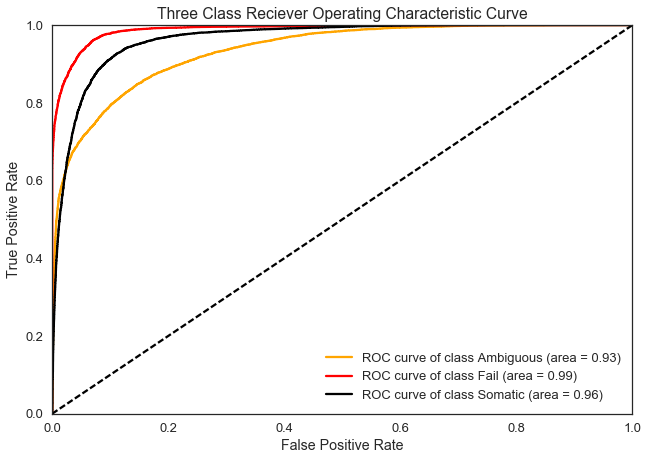

In [21]:
class_lookup = {0: 'Ambiguous', 1: 'Fail', 2: 'Somatic'}
fig, ax = plt.subplots()
create_roc_curve(Y_train, probabilities, class_lookup, 'Three Class Reciever '
                'Operating Characteristic Curve',ax)

confidence intervals +-:  [ 0.00062248  0.00456623  0.0074501   0.009447    0.01037292  0.01143201
  0.01109529  0.00861871  0.00542386  0.00122206]


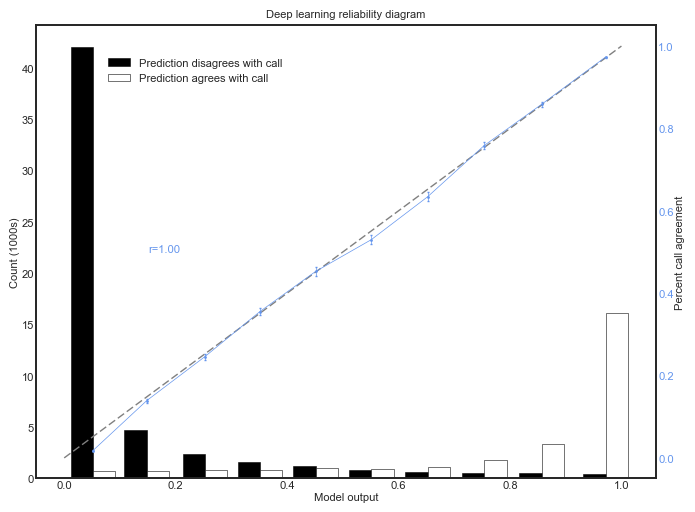

In [22]:
fig, ax = plt.subplots(figsize=(8,6),dpi=100)
lgd = create_reliability_diagram(probabilities, Y_train,['Ambiguous','Fail','Somatic'], 'cornflowerblue', 'Deep learning reliability diagram',
                                 ax, True, True, True)
lgd.set_bbox_to_anchor((0.1, .85))

### Examine reliability per class call

confidence intervals +-:  [ 0.00135697  0.00597271  0.00959394  0.01293291  0.01499473  0.01900697
  0.01987522  0.01710728  0.01035055  0.00301243]


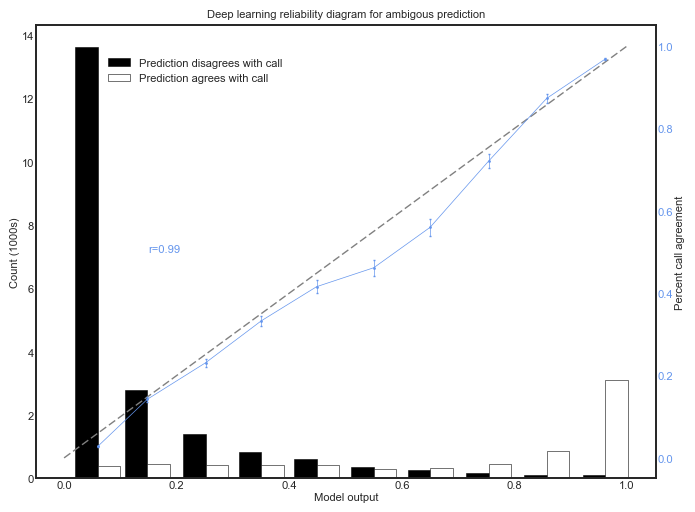

In [23]:
fig, ax = plt.subplots(figsize=(8,6),dpi=100)
lgd = create_reliability_diagram(probabilities[:,:1], Y_train[:,:1],['Ambiguous'], 'cornflowerblue', 'Deep learning reliability diagram for ambigous prediction',
                                 ax, True, True, True)
lgd.set_bbox_to_anchor((0.1, .85))

confidence intervals +-:  [ 0.00068762  0.01350633  0.0196033   0.02160038  0.02095894  0.0217227
  0.02218137  0.01941442  0.01545383  0.00128575]


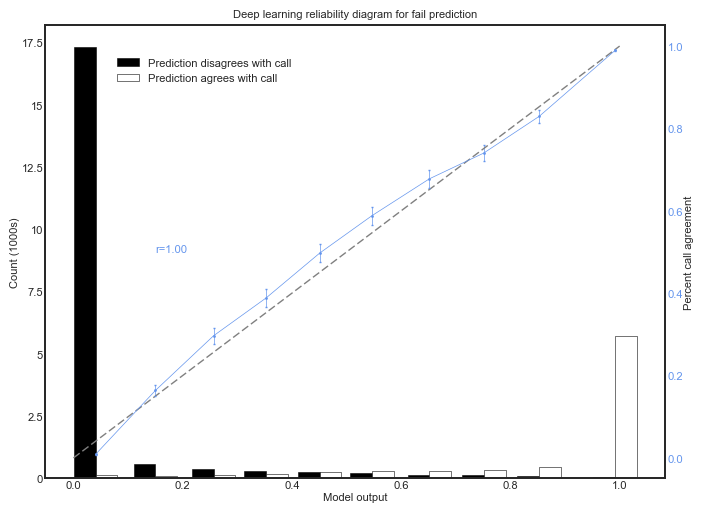

In [24]:
fig, ax = plt.subplots(figsize=(8,6),dpi=100)
lgd = create_reliability_diagram(probabilities[:,1:2], Y_train[:,1:2],['Fail'], 'cornflowerblue', 'Deep learning reliability diagram for fail prediction',
                                 ax, True, True, True)
lgd.set_bbox_to_anchor((0.1, .85))

confidence intervals +-:  [ 0.0012534   0.00820249  0.01464484  0.01790028  0.01953831  0.0187247
  0.01648875  0.01151324  0.00694974  0.00213015]


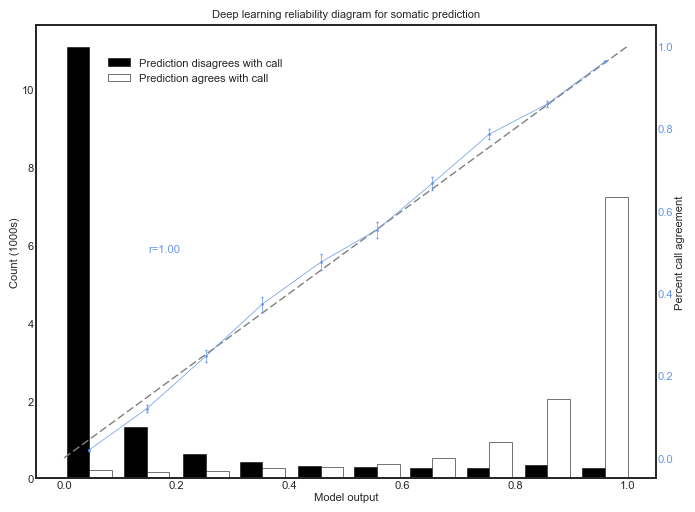

In [25]:
fig, ax = plt.subplots(figsize=(8,6),dpi=100)
lgd = create_reliability_diagram(probabilities[:,2:3], Y_train[:,2:3],['Somatic'], 'cornflowerblue', 'Deep learning reliability diagram for somatic prediction',
                                 ax, True, True, True)
lgd.set_bbox_to_anchor((0.1, .85))

## Feature importance analysis for three class classifier

In [26]:
feature_importances = pd.DataFrame()
for i in range(15):
    estimator.fit(X_train, Y_train)
    feat_import = determine_feature_importance(estimator, X_train, Y_train, False)
    feat_import.set_index('feature', inplace=True)
    feature_importances = pd.concat((feature_importances, feat_import))
feature_importances = feature_importances.groupby(feature_importances.index).mean()
feature_importances.reset_index(level=0, inplace=True)
feature_importances.sort_values('delta_auc', inplace=True, ascending=False)
feature_importances.to_pickle('../data/deep_learning/feature_import.pkl')

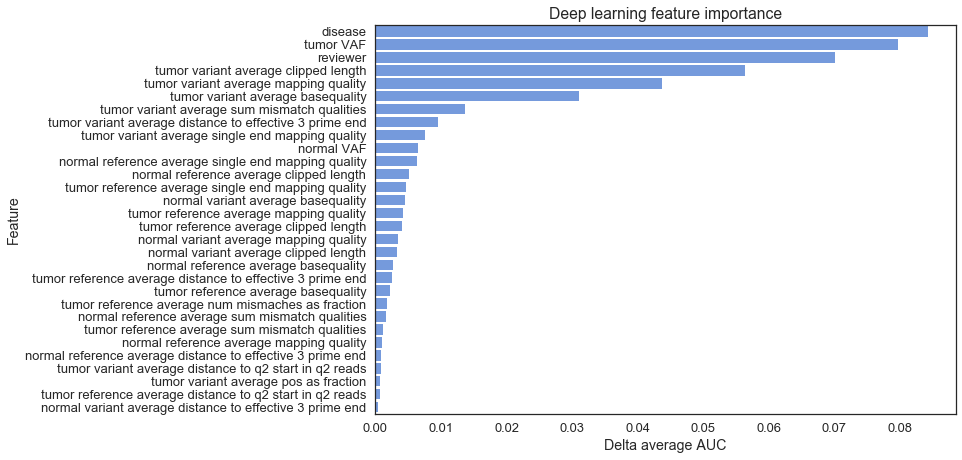

In [66]:
create_feature_importance_plot(feature_importances, 'Deep learning feature importance')

### 1/3 Hold out set analysis

In [68]:
test_probs = estimator.predict_proba(X_test)

In [69]:
np.save('../data/deep_learning/hold_out_test_probs.npy', test_probs)
np.save('../data/deep_learning/hold_out_test_y.npy', Y_test)

In [70]:
X_test.shape

(13530, 71)

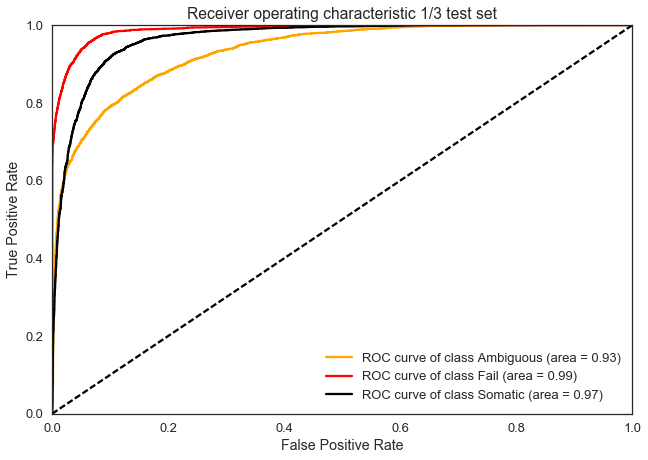

In [71]:
fig, ax = plt.subplots()
create_roc_curve(Y_test, test_probs, class_lookup, 'Receiver operating'
                 ' characteristic 1/3 test set', ax)

confidence intervals +-:  [ 0.00089425  0.00701974  0.01128882  0.01412741  0.01543416  0.01630776
  0.01646538  0.01360608  0.00848409  0.0018792 ]


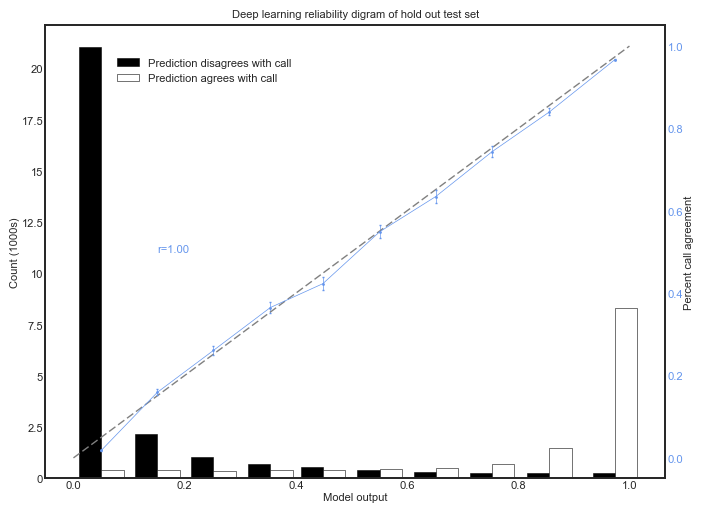

In [72]:
fig, ax = plt.subplots(figsize=(8,6),dpi=100)
lgd = create_reliability_diagram(test_probs, Y_test,['Ambiguous','Fail','Somatic'], 'cornflowerblue', 'Deep learning reliability digram of hold out test set',
                                 ax, True, True, True)
lgd.set_bbox_to_anchor((0.1, .85))

# Solid vs blood tumor
Is the importance of the disease feature in the above results correspond to the known tendency for blood cancers to contain tumor cell contamination of the normal sample?

To test this question, all disease columns were recoded into a single binary variable 'solid_tumor', where False is a blood cancer (liquid tumor) and True is a solid tumor. If performance is approximately the same as earlier results, it is likely that the disease feature is based on the difference between solid and liquid tumors. Simplifying this variable would allow the model to be run on a variety of diseases.

In [73]:
three_class = training_data.replace('g','f')

In [74]:
s_v_b = three_class
s_v_b['solid_tumor'] = s_v_b[['disease_GST', 'disease_MPNST', 'disease_SCLC',
                              'disease_breast', 'disease_colorectal', 
                              'disease_glioblastoma', 'disease_melanoma']].apply(any, axis=1).astype(int)
s_v_b.drop(['disease_AML', 'disease_GST', 'disease_MPNST', 'disease_SCLC',
       'disease_breast', 'disease_colorectal', 'disease_glioblastoma',
       'disease_lymphoma', 'disease_melanoma'], axis=1, inplace=True)

In [75]:
s_v_b.groupby('call').size()

call
a    10643
f    11976
s    18381
dtype: int64

In [76]:
# Get Labels
Y = pd.get_dummies(three_class.call).astype(float).values
# Get training data as numpy array
X = s_v_b.drop(['call'], axis=1).astype(float).values

In [77]:
X.shape

(41000, 63)

In [78]:
Y.shape

(41000, 3)

In [79]:
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

In [80]:
# define baseline model
def baseline_model():
    # create model
    model = Sequential()
    model.add(Dense(63, input_dim=63, kernel_initializer='normal', activation='tanh', kernel_regularizer=l2(0.001)))
    model.add(Dense(20, activation='tanh', kernel_regularizer=l2(0.001)))
    model.add(Dense(20, activation='tanh', kernel_regularizer=l2(0.001)))
    model.add(Dense(20, activation='tanh', kernel_regularizer=l2(0.001)))
    model.add(Dense(20, activation='tanh', kernel_regularizer=l2(0.001)))
    model.add(Dense(3, kernel_initializer='normal', activation='softmax'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [81]:
estimator = KerasClassifier(build_fn=baseline_model, epochs=700, batch_size=2000, verbose=0)

In [82]:
kfold = KFold(n_splits=10, shuffle=True, random_state=seed)

In [83]:
if not os.path.exists('../data/deep_learning/solid_v_blood_regularization.npy'):
    probabilities = cross_val_predict(estimator, X, Y, cv=kfold, method='predict_proba')
    np.save('../data/deep_learning/solid_v_blood_regularization.npy', probabilities)
else:
    probabilities = np.load('../data/deep_learning/solid_v_blood_regularization.npy')

In [84]:
np.save('../data/deep_learning/solid_v_blood_y.npy', Y)

In [85]:
predicted = np.array([list(a).index(max(list(a))) for a in list(probabilities)])

In [86]:
label_binarizer = preprocessing.LabelBinarizer()

label_binarizer.fit(range(max(predicted)+1))
predicted_transformed = label_binarizer.transform(predicted)

#### Classification report
* 0 = ambiguous
* 1 = fail
* 2 = somatic

In [87]:
print_accuracy_and_classification_report(Y, predicted_transformed)

Cross validation accuracy:
	 0.860780487805

Cross validation classification report

             precision    recall  f1-score   support

          0       0.79      0.72      0.76     10643
          1       0.90      0.91      0.90     11976
          2       0.87      0.91      0.89     18381

avg / total       0.86      0.86      0.86     41000



### The simplified 'solid tumor' variable maintains performance seen in earlier models
The 'solid tumor' variable adequately replaces listing individual diseases. Using this variable going forward will allow for more types of tumors to be called by this model

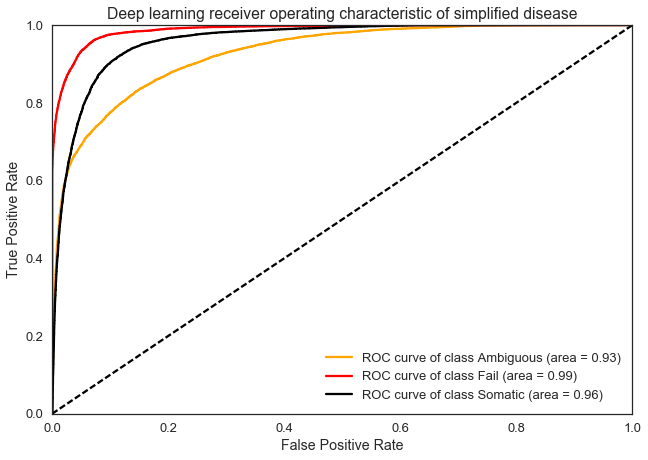

In [88]:
class_lookup = {0: 'Ambiguous', 1: 'Fail', 2: 'Somatic'}
fig, ax = plt.subplots()
create_roc_curve(Y, probabilities, class_lookup, 'Deep learning receiver '
                 'operating characteristic of simplified disease', ax)

confidence intervals +-:  [ 0.00052688  0.00341899  0.00591293  0.00770894  0.00877777  0.00920436
  0.00858335  0.00659297  0.00397114  0.00108234]


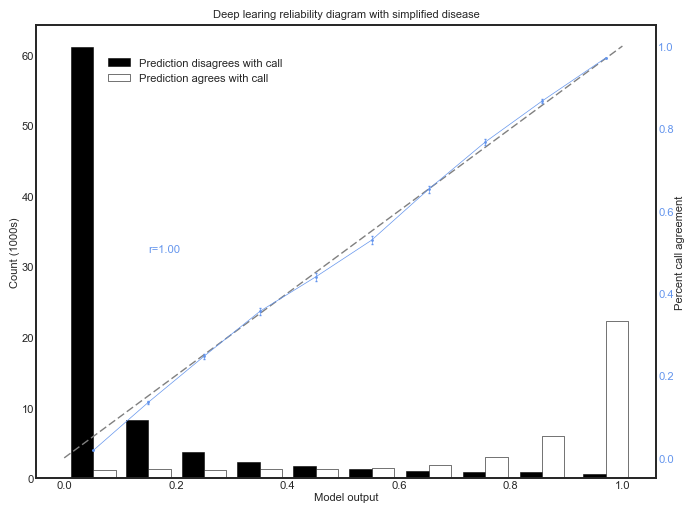

In [89]:
fig, ax = plt.subplots(figsize=(8,6),dpi=100)
lgd = create_reliability_diagram(probabilities, Y,['Ambiguous','Fail','Somatic'], 'cornflowerblue', 'Deep learing reliability diagram with simplified disease',
                                 ax, True, True, True)
lgd.set_bbox_to_anchor((0.1, .85))

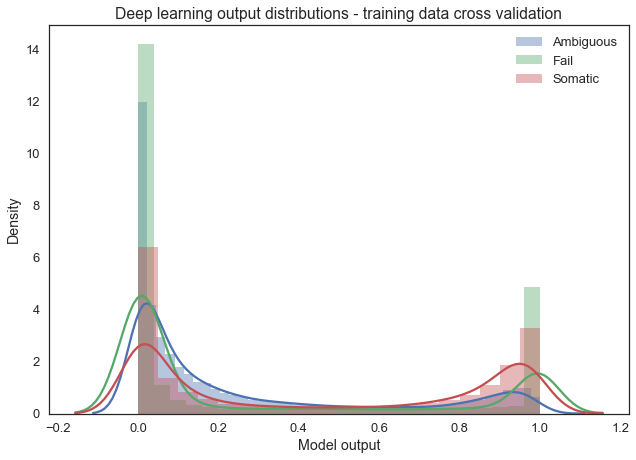

In [90]:
make_model_output_plot(probabilities, 'Deep learning output distributions -'
                       ' training data cross validation')

### Calculate kappa of model cross validation predictions

In [91]:
kappa_table = Y + predicted_transformed

In [92]:
calculate_kappa(kappa_table)

0.78329287187711594

## Remove reviewer to simulate performance on de novo datasets

In [93]:
# Get Labels
Y = pd.get_dummies(three_class.call).astype(float).values
# Get training data as numpy array
X = s_v_b.drop(['call', 'reviewer_1', 'reviewer_2',
                'reviewer_3', 'reviewer_4'] , axis=1).astype(float).values

In [94]:
X.shape

(41000, 59)

In [95]:
Y.shape

(41000, 3)

In [96]:
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

In [97]:
# define baseline model
def baseline_model():
    # create model
    model = Sequential()
    model.add(Dense(59, input_dim=59, kernel_initializer='normal', activation='tanh', kernel_regularizer=l2(0.001)))
    model.add(Dense(20, activation='tanh', kernel_regularizer=l2(0.001)))
    model.add(Dense(20, activation='tanh', kernel_regularizer=l2(0.001)))
    model.add(Dense(20, activation='tanh', kernel_regularizer=l2(0.001)))
    model.add(Dense(20, activation='tanh', kernel_regularizer=l2(0.001)))
    model.add(Dense(3, kernel_initializer='normal', activation='softmax'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [98]:
estimator = KerasClassifier(build_fn=baseline_model, epochs=700, batch_size=2000, verbose=0)

In [99]:
kfold = KFold(n_splits=10, shuffle=True, random_state=seed)

In [100]:
if not os.path.exists('../data/deep_learning/noreviewer_probs_regularization.npy'):
    probabilities = cross_val_predict(estimator, X, Y, cv=kfold, method='predict_proba')
    np.save('../data/deep_learning/noreviewer_probs_regularization.npy', probabilities)
else:
    probabilities = np.load('../data/deep_learning/noreviewer_probs_regularization.npy')

In [101]:
predicted = np.array([list(a).index(max(list(a))) for a in list(probabilities)])

In [102]:
label_binarizer = preprocessing.LabelBinarizer()

label_binarizer.fit(range(max(predicted)+1))
predicted_transformed = label_binarizer.transform(predicted)

#### Classification report
* 0 = ambiguous
* 1 = fail
* 2 = somatic

In [103]:
print_accuracy_and_classification_report(Y, predicted_transformed)

Cross validation accuracy:
	 0.849731707317

Cross validation classification report

             precision    recall  f1-score   support

          0       0.77      0.69      0.73     10643
          1       0.89      0.90      0.90     11976
          2       0.86      0.91      0.88     18381

avg / total       0.85      0.85      0.85     41000



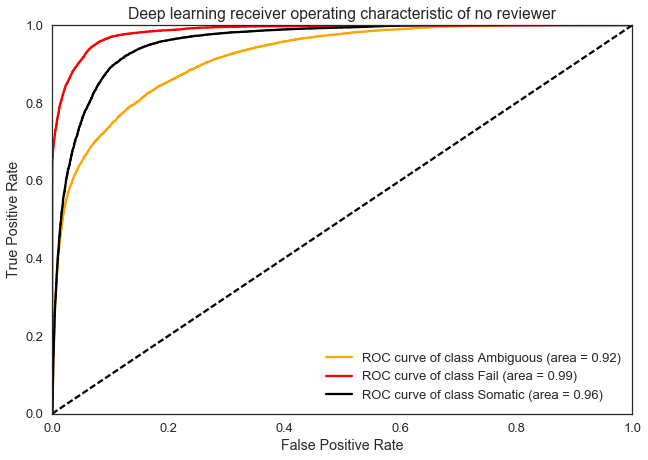

In [104]:
class_lookup = {0: 'Ambiguous', 1: 'Fail', 2: 'Somatic'}
fig, ax = plt.subplots()
create_roc_curve(Y, probabilities, class_lookup, 'Deep learning receiver '
                 'operating characteristic of no reviewer', ax=ax)

confidence intervals +-:  [ 0.00054063  0.00342791  0.00562326  0.00748434  0.00815918  0.00873999
  0.00808578  0.00647762  0.00413643  0.0011306 ]


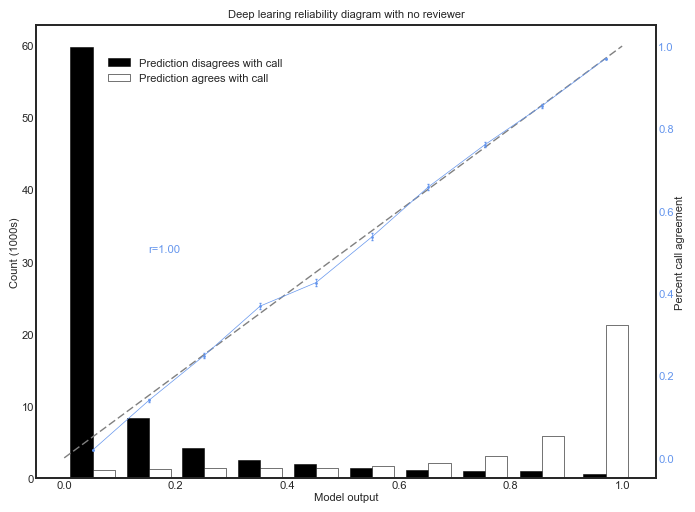

In [105]:
fig, ax = plt.subplots(figsize=(8,6),dpi=100)
lgd = create_reliability_diagram(probabilities, Y,['Ambiguous','Fail','Somatic'], 'cornflowerblue', 'Deep learing reliability diagram with no reviewer',
                                 ax, True, True, True)
lgd.set_bbox_to_anchor((0.1, .85))

In [106]:
cv_somatic_error = get_somatic_error_type(Y, predicted)

In [107]:
cv_somatic_error.index = training_data.index

In [108]:
probs_df = pd.DataFrame(probabilities, columns=['Ambiguous', 'Fail', 'Somatic'], index=training_data.index)

In [109]:
cv_somatic_error = pd.concat([cv_somatic_error, probs_df], axis=1)

In [110]:
cv_somatic_error.to_pickle('../data/deep_learning/xval_model_results.pkl')

# Independent test set analysis

In [111]:
# Get Labels
Y = pd.get_dummies(three_class.call).astype(float).values
# Get training data as numpy array, remove reviews because of non overlap
X = s_v_b.sort_index(axis=1).drop(['call', 'reviewer_1',
                'reviewer_2', 'reviewer_3', 
                'reviewer_4'], axis=1).astype(float).values

In [112]:
X.shape

(41000, 59)

In [113]:
# define baseline model
def model():
    # create model
    model = Sequential()
    model.add(Dense(59, input_dim=59, kernel_initializer='normal', activation='tanh', kernel_regularizer=l2(0.001)))
    model.add(Dense(20, activation='tanh', kernel_regularizer=l2(0.001)))
    model.add(Dense(20, activation='tanh', kernel_regularizer=l2(0.001)))
    model.add(Dense(20, activation='tanh', kernel_regularizer=l2(0.001)))
    model.add(Dense(20, activation='tanh', kernel_regularizer=l2(0.001)))
    model.add(Dense(3, kernel_initializer='normal', activation='softmax'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [114]:
estimator = KerasClassifier(build_fn=model, epochs=1000, batch_size=2000, verbose=0)

In [115]:
estimator.fit(X, Y)

## SCLC

In [116]:
sclc_data = pd.read_pickle('../data/independent_test/sclc_train.pkl')
sclc_data['solid_tumor'] = 1

In [117]:
sclc_call = pd.read_pickle('../data/independent_test/sclc_call.pkl')
sclc_call=sclc_call.map(str.lower).replace('g','f').replace('s\x03', 's').replace('', 'f')
sclc_call.value_counts()

s    2526
f     145
a      15
Name: call, dtype: int64

In [118]:
# Get Labels
sclc_Y = pd.get_dummies(sclc_call).astype(float).values
# Get training data as numpy array
sclc_X = sclc_data.sort_index(axis=1).drop(['disease_SCLC', 'reviewer_Erica', 'reviewer_Lee'], axis=1).astype(float).values

In [119]:
sclc_probs = estimator.predict_proba(sclc_X)

In [120]:
np.save('../data/deep_learning/sclc_y.npy', sclc_Y)
np.save('../data/deep_learning/sclc_probs.npy', sclc_probs)

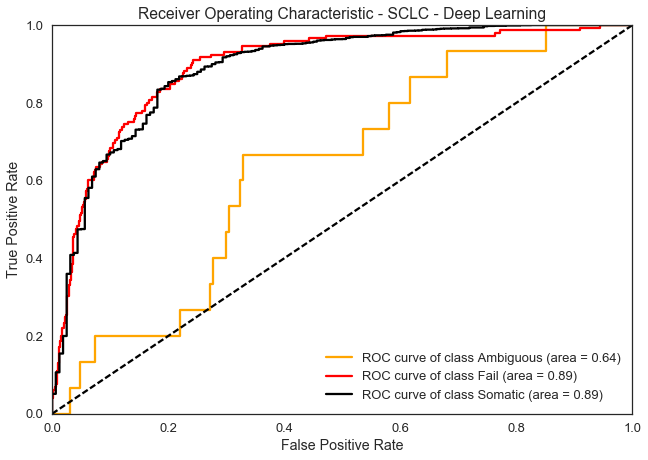

In [121]:
fig, ax = plt.subplots()
create_roc_curve(sclc_Y, sclc_probs, class_lookup, 
                 'Receiver Operating Characteristic - SCLC - Deep Learning', ax)

confidence intervals +-:  [ 0.00204857  0.03515865  0.04893442  0.0631245   0.08229345  0.08155736
  0.0741619   0.06237404  0.04637841  0.00345201]


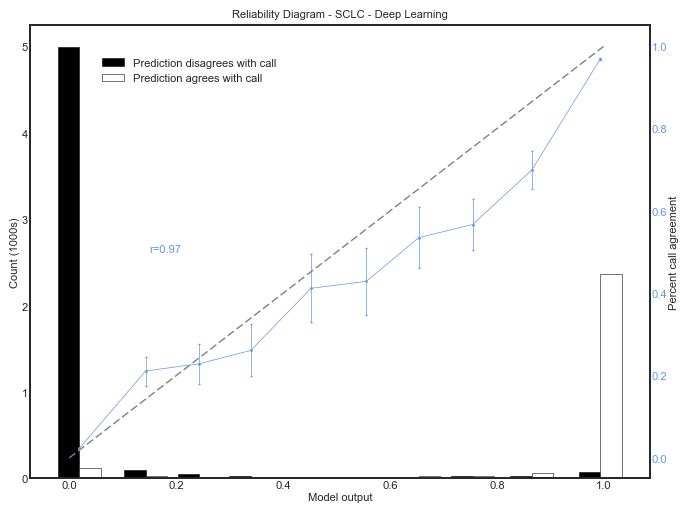

In [122]:
fig, ax = plt.subplots(figsize=(8,6),dpi=100)
lgd = create_reliability_diagram(sclc_probs, sclc_Y,
                                 ['Ambiguous','Fail','Somatic'], 
                                 'cornflowerblue', 
                                 'Reliability Diagram - SCLC - Deep Learning',
                                 ax, True, True, True)
lgd.set_bbox_to_anchor((0.1, .85))

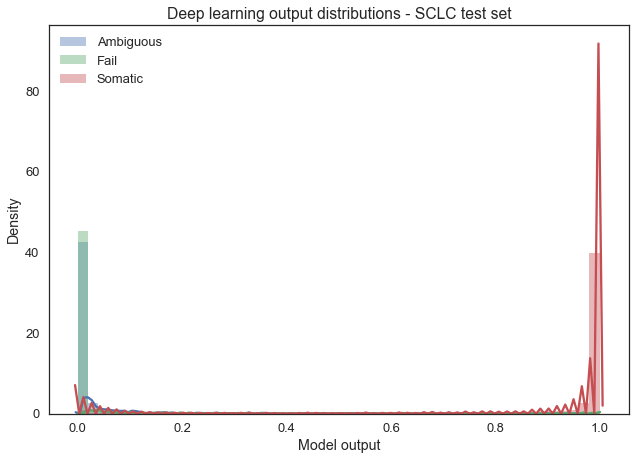

In [123]:
make_model_output_plot(sclc_probs, 'Deep learning output distributions -'
                       ' SCLC test set')

In [124]:
label_binarizer.fit(range(max(estimator.predict(sclc_X))+1))
sclc_predicted_transformed = label_binarizer.transform(estimator.predict(sclc_X))

calculate_kappa(sclc_predicted_transformed+sclc_Y)

0.31484420141775932

In [125]:
metrics.cohen_kappa_score(np.argmax(sclc_Y, axis=1), estimator.predict(sclc_X))

0.31674691446512249

In [126]:
auc = []

for i in np.arange(0, 0.8, 0.05):
    if i == 0:
        sclc_X_test = sclc_X
        sclc_Y_test = sclc_Y
        X_train = X
        Y_train = Y
    else:
        (sclc_X_train, sclc_X_test, 
         sclc_Y_train, sclc_Y_test) = train_test_split(sclc_X, sclc_Y, 
                                                       train_size=i,
                                                       random_state=seed, 
                                                       stratify=sclc_Y) 
        X_train = np.concatenate((X, sclc_X_train))
        Y_train = np.concatenate((Y, sclc_Y_train))
    print('Percentage of test data included in training: ', i*100)
    print('Training data shape: ', X_train.shape)
    print('Test data shape: ', sclc_X_test.shape)
    print('Number of test samples included in training: ', X_train.shape[0]-X.shape[0])
    estimator.fit(X_train, Y_train)
    X_test_probs = estimator.predict_proba(sclc_X_test)
    print_accuracy_and_classification_report(sclc_Y_test, predict_classes(X_test_probs))
    temp_auc = []
    temp_auc.append(X_train.shape[0]-X.shape[0])
    for j in range(Y.shape[1]):
        temp_auc.append(metrics.roc_auc_score(sclc_Y_test[:, j], X_test_probs[:, j]))
    auc.append(temp_auc)
    print('Test AUC: ', temp_auc)
    print('---------------------------------------------------------')

Percentage of test data included in training:  0.0
Training data shape:  (41000, 59)
Test data shape:  (2686, 59)
Number of test samples included in training:  0
Cross validation accuracy:
	 0.938198064036

Cross validation classification report

             precision    recall  f1-score   support

          0       0.00      0.00      0.00        15
          1       0.45      0.17      0.24       145
          2       0.95      0.99      0.97      2526

avg / total       0.92      0.94      0.93      2686

Test AUC:  [0, 0.79872706851366537, 0.87348179511188917, 0.87018136381631028]
---------------------------------------------------------
Percentage of test data included in training:  5.0
Training data shape:  (41134, 59)
Test data shape:  (2552, 59)
Number of test samples included in training:  134
Cross validation accuracy:
	 0.941222570533

Cross validation classification report

             precision    recall  f1-score   support

          0       0.00      0.00      0.00    

Cross validation accuracy:
	 0.945802337938

Cross validation classification report

             precision    recall  f1-score   support

          0       0.00      0.00      0.00         3
          1       0.67      0.48      0.56        61
          2       0.97      0.98      0.98       877

avg / total       0.95      0.95      0.95       941

Test AUC:  [1745, 0.92537313432835822, 0.91615126676602077, 0.95214509692132276]
---------------------------------------------------------
Percentage of test data included in training:  70.0
Training data shape:  (42880, 59)
Test data shape:  (806, 59)
Number of test samples included in training:  1880
Cross validation accuracy:
	 0.956575682382

Cross validation classification report

             precision    recall  f1-score   support

          0       0.00      0.00      0.00         3
          1       0.77      0.49      0.60        49
          2       0.97      0.99      0.98       754

avg / total       0.95      0.96      0.95  

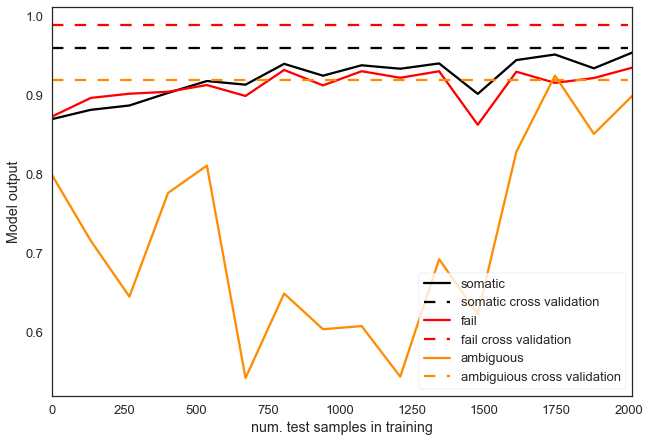

In [127]:
try:
    sclc_auc = pd.DataFrame(auc, columns=['num. test samples in training','ambiguous', 'fail','somatic'])
    sclc_auc.to_pickle('../data/deep_learning/sclc_batch_effect_correction_dropout.pkl')
except NameError:
    sclc_auc = pd.read_pickle('../data/deep_learning/sclc_batch_effect_correction_dropout.pkl')
fig, ax = plt.subplots(1, 1)
sclc_auc.plot(x='num. test samples in training', y='somatic', ax=ax, color='black')
ax.plot([0, 2000], [.96,.96], linestyle='--', dashes=(5, 5),color='black', label='somatic cross validation')
sclc_auc.plot(x='num. test samples in training', y='fail', ax=ax, color='red')
ax.plot([0, 2000], [.99,.99], linestyle='--', dashes=(5, 5),color='red', label='fail cross validation')
sclc_auc.plot(x='num. test samples in training', y='ambiguous', ax=ax, color='darkorange')
ax.plot([0, 2000], [.92,.92], linestyle='--', dashes=(5, 5),color='darkorange', label='ambiguious cross validation')
ax.set_ylabel('Model output')
ax.legend(loc=4,frameon=True)

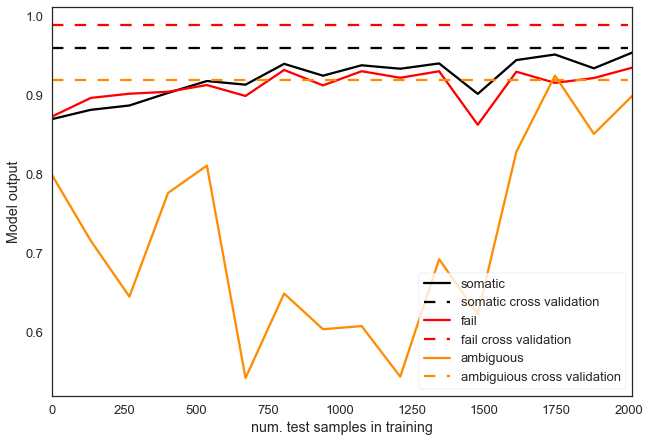

In [128]:
try:
    sclc_auc = pd.DataFrame(auc, columns=['num. test samples in training','ambiguous', 'fail','somatic'])
    sclc_auc.to_pickle('../data/deep_learning/sclc_batch_effect_correction.pkl')
except NameError:
    sclc_auc = pd.read_pickle('../data/deep_learning/sclc_batch_effect_correction.pkl')
fig, ax = plt.subplots(1, 1)
sclc_auc.plot(x='num. test samples in training', y='somatic', ax=ax, color='black')
ax.plot([0, 2000], [.96,.96], linestyle='--', dashes=(5, 5),color='black', label='somatic cross validation')
sclc_auc.plot(x='num. test samples in training', y='fail', ax=ax, color='red')
ax.plot([0, 2000], [.99,.99], linestyle='--', dashes=(5, 5),color='red', label='fail cross validation')
sclc_auc.plot(x='num. test samples in training', y='ambiguous', ax=ax, color='darkorange')
ax.plot([0, 2000], [.92,.92], linestyle='--', dashes=(5, 5),color='darkorange', label='ambiguious cross validation')
ax.set_ylabel('Model output')
ax.legend(frameon=True)